In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# default_exp multiclass

In [ ]:
# export
import shutil
from random import randint
from os import path,listdir
from shutil import rmtree
from tempfile import TemporaryDirectory
from itertools import product

from mimesis import Text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf

# Multiclass 
> Classifier for multiple classes in NLP

The classifier is based on `tf.estimator` method of Tensorflow. Datasets of email responses are used for testing. 

In [ ]:
#hide
#Shut down logging except Error
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Processing

The dataset of email responses is loaded from a csv file.  Three steps make up the data processing Multiclass:  
Load the data -->  Make train-test split  -->  Create the Tensorflow input functions

Load and split the data using the Pandas library.  

In [ ]:
# export

def split_dataframe(df, **kwargs):
    '''Split with the pandas `sample` method.
    '''
    train = df.sample(**kwargs)
    test = df.drop(train.index)

    return {'train': train, 'test': test}

def balanced_labels_in_split(df, **kwargs):
    '''Give a balanced train-test split in all the different classes
    '''
    groups = iter(df.groupby('sentiment'))
    train_df, test_df = split_dataframe(next(groups)[1], **kwargs).values()
    for _, group in groups:
        train, test = split_dataframe(group, **kwargs).values()
        train_df = pd.concat([train_df, train])
        test_df = pd.concat([test_df, test])

    return {'train': train_df, 'test': test_df}

Test these function with the following example

In [ ]:
text = Text('en') #text mocker
sentiments = lambda sentiment, n: {'sentiment': [sentiment for _ in range(n)],
                                   'payload': [text.quote()for _ in range(n)]}
df_example_f = lambda sentiment, ni, nf: pd.DataFrame(
    sentiments(sentiment, nf - ni), index=range(ni, nf)
).sample(nf - ni)
df_a =  df_example_f(1,0,100) # positive
df_b = df_example_f(0,150,200) # negative
df_c  = df_example_f(2,300,400) # neutral

In [ ]:
random_state = randint(0, 2**32)
split_aa = split_dataframe(df_a, random_state=random_state, frac=.55)
split_bb = split_dataframe(df_a, random_state=random_state, frac=.55)

assert all(
    np.all((split_aa[k] == split_bb[k]).values) for k in ('train', 'test')
)

In [ ]:
train, test = split_dataframe(df_a, frac=0.7).values()
assert train.shape[0] == 70 and test.shape[0] == 30

dataset = pd.concat([df_a, df_b,df_c]).sample(frac=1.0)
train, test = balanced_labels_in_split(dataset, frac=.8).values()

assert dataset.size == train.size + test.size
assert train.size and dataset.size

random_state = randint(0, 2**32)
balanced1 = balanced_labels_in_split(dataset, random_state=random_state, frac=.65)
balanced2 = balanced_labels_in_split(dataset, random_state=random_state, frac=.65)
assert all(
    np.all((balanced1[k] == balanced2[k]).values) for k in ('train', 'test')
)

The Tensorflow input functions are the input elements of the Tensorflow algorithms.
These functions are created with the help of the `tf.estimator.inputs` module

In [ ]:
# export
def tf_input_fn(df, **kwargs):
    ''' Load a TF function for a DataFrame
    ''' 
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        df, df['label'], **kwargs
    )


def train_input_fs(**kwargs):
    '''TF functions with parameters for training
    '''
    return {
        name: tf_input_fn(df, shuffle=True, num_epochs=None)
        for name, df in kwargs.items()
    }


def predict_input_fs(**kwargs):
    '''TF with parameters for testing
    '''
    return {name: tf_input_fn(df, shuffle=False) for name, df in kwargs.items()}

**Load and split the dataset**

In [ ]:
df = pd.read_csv('../data/raw/sibatel_web_intekglobal_payloads.csv')
categories = pd.Categorical(df.sentiment)
df['label'] = categories.codes.astype(np.int32)
dfs = balanced_labels_in_split(df,frac=0.6)

The percentages across over all splits are preserved

In [ ]:
sentiment_rate = lambda df: {
    name: group.shape[0] / df.shape[0]
    for name, group in df.groupby('sentiment')
}

data_ = sentiment_rate(df)
train_ = sentiment_rate(dfs['train'])
test_ = sentiment_rate(dfs['test'])
eq_ = lambda *x: all(abs(x[0] - y) < 10**(-2) for y in x)

print(data_)

assert all(
    eq_(data_[label], train_[label], test_[label])
    for label in categories.categories
)

{'negative': 0.3801369863013699, 'neutral': 0.1678082191780822, 'positive': 0.4520547945205479}


Sample of the train dataset

In [ ]:
dfs['train'].sample(2)

,payload,sentiment,mocker,label
278,\ni have received a mail on a job offer in the...,positive,Enrique,2
242,thank you for this email and glad that you fou...,positive,Enrique,2


**Load Tensorflow input functions**

In [ ]:
train_input_fn = train_input_fs(train = dfs['train'])
predict_input_fn =  predict_input_fs(**dfs)

## Set up the Model

***Feature columns***

From the TF-Hub [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md)
we use the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). Some important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [ ]:
#export
def embedded_text_feature_column_f(module_spec="https://tfhub.dev/google/nnlm-en-dim128/1"):
    ''' Call the text embedding from the TF-Hub library
    '''
    return hub.text_embedding_column(
        key="payload", module_spec=module_spec
    )

Load the embedded text feature column. If it's called it for the first time, it may take time to download it (it weights around 500 MB)

In [ ]:
embedded_text_feature_column = embedded_text_feature_column_f()

***Premade Estimators***

For classification, we use a default premade [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier). One can overwrite it with another classifier.

In [ ]:
# export
def load_estimator(
    embedded_text_feature_column, estimator_f=tf.estimator.DNNClassifier,model_dir = None,n_classes=2
):
    ''' Load the TF `estimator`
    '''
    return estimator_f(
        model_dir = model_dir,
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=n_classes,
        optimizer=tf.keras.optimizers.Adagrad(lr=0.003)
    )

In [ ]:
estimator = load_estimator(embedded_text_feature_column,n_classes=3)

When no *model_dir* is provided, the `estimator` is stored in a temporary file. A deletion of an  `estimator` (either explicit or by the garbage collector) does not erase its corresponding directory from the disk

In [ ]:
model_dir = estimator.model_dir
del estimator 
assert path.isdir(model_dir)
rmtree(model_dir)
estimator = load_estimator(embedded_text_feature_column,n_classes=3)

## Train, Evaluate and Predict

Train the estimator for a reasonable amount of steps.  
Training for 5,000 steps means 640,000 training examples with the default
batch size (128).   
This is roughly equivalent to 640,000/363 ~ 1700 epochs since the training dataset
contains 363 examples.

In [ ]:
#export
def train(estimator, train_input_fn,steps=5000):
    '''Train with TF `estimator.train`
    '''
    result = {}
    for name,input_fn in train_input_fn.items():
        result[name] = estimator.train(input_fn=input_fn, steps=steps)
    return result

In [ ]:
train(estimator,train_input_fn,steps=3000)

{'train': <tensorflow_estimator.python.estimator.canned.dnn.DNNClassifierV2 at 0x7f28885f6090>}

In [ ]:
# export
def evaluate(estimator, **args:tf_input_fn):
    '''Evaluate with TF `estimator.evaluate`
    '''
    results = {}
    for name,input_fn in args.items():
        results[name] = estimator.evaluate(input_fn=input_fn)
    return results

In [ ]:
#export
def predict(estimator, df_examples):
    ''' Predict with TF `estimator.predict` and from a dataframe of payloads.
    '''

    def predict_from_input_fn(estimator, **input_fns):
        res = {}
        for name, input_fn in input_fns.items():
            res[name] = np.array(
                [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
            )
        return res

    return predict_from_input_fn(
        estimator, **predict_input_fs(examples=df_examples)
    )['examples']

Evaluate:

In [ ]:
eval_results = evaluate(estimator,**predict_input_fn)

In [ ]:
eval_results['train']

{'accuracy': 0.9142857,
 'average_loss': 0.29477313,
 'loss': 0.28114003,
 'global_step': 3000}

In [ ]:
print("Training set accuracy: {accuracy}".format(**eval_results['train']))
print("Test set accuracy: {accuracy}".format(**eval_results['test']))

Training set accuracy: 0.9142857193946838
Test set accuracy: 0.6752136945724487


Predict:

In [ ]:
predict(estimator, dfs['test'].sample(5)) 

array([2, 0, 2, 2, 2])

It is desirable a predictor that inputs from a string. The function `sentiment` covers this role.

In [ ]:
# export
def sentiment(estimator, doc,categories):
    ''' Gets the sentiment of the *doc* string
    '''
    doc_df = pd.DataFrame(
        [{
            'payload': doc,
            'sentiment': 'unknown',
            'label': 'unknown'
        }]
    )
    pred = categories.categories[predict(estimator, doc_df)[0]]
    return pred 

In [ ]:
example_str = ''' thank you for offering me the position of Merchandiser with Thomas Ltd.
i am thankful to accept this job offer and look ahead to starting my career with your company
on June 27, 2000.'''
sentiment(estimator,example_str,categories=categories)

'positive'

***Confusion matrix***  
The function `plot_confusion_matrix` plots the corresponding confusion matrix over a dataframe and its corresponding Tensorflow function. The confusion matrix helps  to understand the distribution of misclassifications.

In [ ]:
# export
def plot_confusion_matrix(df_data, estimator, input_fn, header, labels):
    ''' Plot the Confusion Matrix: ${{TN,FN},{FP,TP}}$
    '''
    def get_predictions(estimator, input_fn):
        return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

    # Create a confusion matrix on dataframe data.
    cm = tf.math.confusion_matrix(
        df_data["label"], get_predictions(estimator, input_fn)
    )
    # Normalize the confusion matrix so that each row sums to 1.
    cm = tf.cast(cm, dtype=tf.float32)
    cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
    plt.title(header)
    plt.xlabel("Predicted")
    plt.ylabel("True")

The Confusion Matrix for the train set case

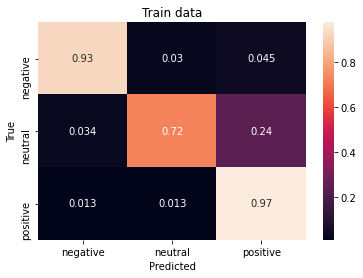

In [ ]:
plot_confusion_matrix(
    dfs['train'],
    estimator,
    predict_input_fn['train'],
    header='Train data',
    labels=categories.categories
)

The Confusion Matrix for the test case

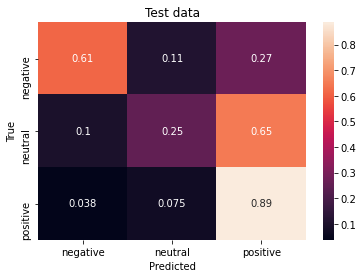

In [ ]:
plot_confusion_matrix(
    dfs['test'],
    estimator,
    predict_input_fn['test'],
    header='Test data',
    labels=categories.categories
)

## Save and Load an Estimator

 The  `export_estimator` function copy the directory of the estimador given in `estimator.model_dir` to a *dst_model*.

In [ ]:
# export
def export_estimator(estimator, dst_estimator):
    ''' Copy the estimator's directory to a new directory
    '''
    shutil.copytree(estimator.model_dir, dst_estimator)

Load the saved estimator using `load_model` and check that the evaluation results are up to date with the latest check point:

In [ ]:
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname, 'tmp')
    export_estimator(estimator, dst_estimator=tmp_dir)
    loaded_estimator_results = evaluate(
        load_estimator(
            embedded_text_feature_column, model_dir=tmp_dir, n_classes=3
        ), **predict_input_fn
    )

In [ ]:
assert loaded_estimator_results == eval_results

Erase all the variables defined so far

In [ ]:
del df,categories, dfs, eval_results, embedded_text_feature_column, loaded_estimator_results

In [ ]:
# export
class Multiclass:
    '''Multiclass classifier that implements the workflow: Load -> Train -> Evaluate.'''
    def __init__(
        self,
        src_file=None,
        n_classes=2,
        estimator_dir=None,
        frac=0.60,
        train_steps=5000,
        random_state=None
    ):
        '''Pass the arguments to class attributes.
           Load and split the data.
        '''
        self.n_classes = n_classes
        self.frac = frac
        self.estimator_dir = estimator_dir
        self._is_estimator_dir = path.isdir(str(estimator_dir))
        self.random_state = random_state
        self.train_steps = train_steps
        self.module_spec = "https://tfhub.dev/google/nnlm-en-dim128/1"

        if src_file is not None:
            self.data = pd.read_csv(src_file)
            self.categories = pd.Categorical(self.data.sentiment)
            self.data['label'] = self.categories.codes.astype(np.int32)
            self.split_dataset()

    def __del__(self):
        ''' Removes the `estimator` and its corresponding directory, 
        unless the estimator_dir is None.
        '''
        if not self._is_estimator_dir:
            rmtree(self.estimator_dir, ignore_errors=True)

    def split_dataset(self):
        ''' Train-test splits. Deletes empty dataframes.
        '''
        self.dfs = balanced_labels_in_split(
            self.data, random_state=self.random_state, frac=self.frac
        )
        if self.dfs['test'].shape[0] == 0:
            del self.dfs['test']
        if self.dfs['train'].shape[0] == 0:
            del self.dfs['train']

    def input_fns(self):
        self.input = {}
        if 'train' in self.dfs.keys():
            self.input['train'] = train_input_fs(train=self.dfs['train'])

        self.input['predict'] = predict_input_fs(**self.dfs)

    def load_estimator(self):
        self.embedded_text_feature_column = embedded_text_feature_column_f(
            module_spec=self.module_spec
        )
        self.estimator = load_estimator(
            self.embedded_text_feature_column,
            model_dir=self.estimator_dir,
            n_classes=self.n_classes
        )
        self.estimator_dir = self.estimator.model_dir

    def train(self):
        if self.input['train'] is not None:
            train(self.estimator, self.input['train'], steps=self.train_steps)

    def evaluate(self):
        self.evaluation = evaluate(self.estimator, **self.input['predict'])

    def plot_confusion_matrix(self, label):
        plot_confusion_matrix(
            self.dfs[label],
            self.estimator,
            self.input['predict'][label],
            header=label + ' data',
            labels = self.categories.categories
        )

    def export_estimator(self, dst_dir):
        try:
            _ = self.estimator
        except:
            self.load_estimator()
        export_estimator(self.estimator, dst_dir)

    def predict(self, df_examples):
        '''Predict from dataframe'''
        return predict(self.estimator, df_examples)

    def sentiment(self, doc):
        return sentiment(self.estimator, doc,categories=self.categories)

    def pipeline(self):
        ''' The pipeline flow is:
            input_fns --> load_estimator --> train --> evaluate
        '''
        self.input_fns()
        self.load_estimator()
        self.train()
        self.evaluate()

In [ ]:
from nbdev.showdoc import *
show_doc(Multiclass.__del__)

<h4 id="Multiclass.__del__" class="doc_header"><code>Multiclass.__del__</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>Multiclass.__del__</code>()

Removes the `estimator` and its corresponding directory, 
unless the estimator_dir is None.

When an estimator is deleted, the corresponding temporary directory is kept in memory

In [ ]:
pl = Multiclass(src_file ='../data/raw/sibatel_web_intekglobal_payloads.csv')
pl.load_estimator()
model_dir  = pl.estimator.model_dir

assert path.isdir(model_dir)
del pl.estimator
assert path.isdir(model_dir)
rmtree(model_dir)

The attribute `__del__`  in the `Multiclass` class fixes this

In [ ]:
pl = Multiclass()
pl.load_estimator()
model_dir  = pl.estimator.model_dir

assert path.isdir(model_dir)
del pl
assert not path.isdir(model_dir)

The deletion of the `Multiclass` instance does not cause the deletion of the estimator directory when the estimator has been previously loaded (specifying it in *estimator_dir*).

In [ ]:
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname, 'tmp')
    pl = Multiclass()
    pl.load_estimator()
    model_dir = pl.estimator.model_dir
    pl.export_estimator(dst_dir=tmp_dir)
    del pl
    
    assert tmp_dir != model_dir
    assert not path.isdir(model_dir) 
    assert path.isdir(tmp_dir)
    
    pl = Multiclass(estimator_dir=tmp_dir)
    del pl 
    
    assert path.isdir(tmp_dir)
    

When the dataframe for training is not provided, the instance of `Multiclass` does not generate the train TF input function 

In [ ]:
text = Text('en')
sentiments = lambda label, n: {
    'sentiment': [['positive', 'negative', 'neutral'][label] for _ in range(n)],
    'label': [label for _ in range(n)],
    'payload': [text.quote() for _ in range(n)]
}
df_example_f = lambda label, ni, nf: pd.DataFrame(
    sentiments(label, nf - ni), index=range(ni, nf)
).sample(nf - ni)

pl = Multiclass()
pl.load_estimator()
pl.dfs = {'test': df_example_f(1, 0, 100)}  #no tes
pl.input_fns()
assert 'train' not in pl.input.keys()
assert 'test' in pl.input['predict'].keys()

In [ ]:
from nbdev.showdoc import *
show_doc(Multiclass.pipeline)

<h4 id="Multiclass.pipeline" class="doc_header"><code>Multiclass.pipeline</code><a href="__main__.py#L96" class="source_link" style="float:right">[source]</a></h4>

> <code>Multiclass.pipeline</code>()

The pipeline flow is:
input_fns --> load_estimator --> train --> evaluate

The `pipeline` calls the functions that prepares the input data, trains the model and stores the results of the evaluation

**After running the `Multiclass`, check that all methods are implemented correctly**

**Three Classes**

In [ ]:
multiclass = Multiclass(
    src_file='../data/raw/sibatel_web_intekglobal_payloads.csv',
    n_classes=3,
    train_steps=3500
)
multiclass.pipeline()

The resulting evaluation is stored in `Multiclass.evaluation`

In [ ]:
multiclass.evaluation.keys()

dict_keys(['train', 'test'])

In [ ]:
multiclass.evaluation['test']    

{'accuracy': 0.6581197,
 'average_loss': 0.74679506,
 'loss': 0.74679506,
 'global_step': 3500}

The confusion matrix for train set

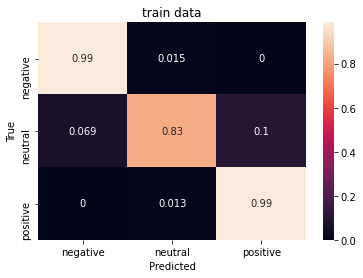

In [ ]:
multiclass.plot_confusion_matrix('train')

The confustion matrix for test set

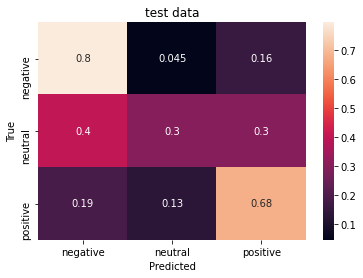

In [ ]:
multiclass.plot_confusion_matrix('test')

Predict examples from dataframe in 0 1 format

In [ ]:
multiclass.predict(multiclass.data.sample(2))

array([1, 0])

**Two Classes**

In [ ]:
m2 = Multiclass(
    src_file='../data/raw/sibatel_web_intekglobal_payloads.csv',
    n_classes=3,
    train_steps=4000
)
m2.pipeline()

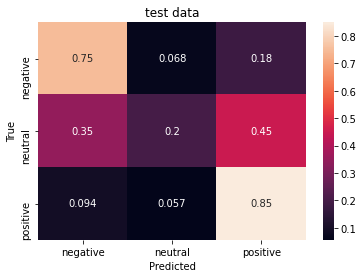

In [ ]:
m2.plot_confusion_matrix('test')

Check that the `export_estimator` is rightly copying the model files

In [ ]:
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname,'tmp')
    multiclass.export_estimator(tmp_dir)
    
    assert listdir(tmp_dir) == listdir(multiclass.estimator.model_dir)

Predict from string

In [ ]:
doc_str='''thank you very much for offering me the opportunity to work at Norris, Wilson and Kelley as Clinical embryologist.\nafter much deliberation, i will not be accepting the position,
as it isn’t the right fit for my long-term career goals.\ni sincerely appreciate the offer and give you
my best wishes in finding a suitable candidate for the position.\ni wish you and the company well 
in all future endeavours.'''
print(multiclass.sentiment(doc_str))

negative


Create an instance of a `Multiclass` and run it (call the  `pipeline` method). Export the `estimator`. 
Create a new instance of  `Multiclass` with the exported estimator directory. Call `evaluate` in this last instance without calling the `train` method.
The resulting evaluations of the two multiclasses must coincide, provided that the `evaluation` is carried out in the same test set \[CAVEAT: They must coincide up to a factor (see below)\]. 

In [ ]:
random_state = randint(0, 2**32 - 1)
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname, 'tmp')
    m1 = Multiclass(
        src_file='../data/interim/payloads.csv', random_state=random_state
    )
    m1.pipeline()
    m1.export_estimator(dst_dir=tmp_dir)
    m2 = Multiclass(
        src_file='../data/interim/payloads.csv',
        estimator_dir=tmp_dir,
        random_state=random_state
    )
    m2.input_fns()
    m2.load_estimator()
    m2.evaluate()

assert m1.evaluation == m1.evaluation

Instantiate the Multiclass class twice with the same seed

In [ ]:
kwargs = {
    'random_state': randint(0, 2**32 - 1),
    'src_file': '../data/raw/sibatel_web_intekglobal_payloads.csv'
}
pl1, pl2 = Multiclass(**kwargs,n_classes=3), Multiclass(**kwargs,n_classes=3)
pl1.pipeline()
pl2.pipeline()


Since the seed is the same from both Multiclasss, the train/test split is the same in both cases

In [ ]:
assert np.all((pl1.dfs['train'] ==pl2.dfs['train']).values)
assert np.all((pl1.dfs['test'] ==pl2.dfs['test']).values)

The Tensorflow training algorithms are not completely [*deterministic*](https://github.com/NVIDIA/tensorflow-determinism). Therefore, the scores in the two Multiclasss are equal up to a factor. Calculate this factor.

In [ ]:
def is_equal_pipe_evals(m, n):
    ''' $error  = m 10^{-n}$
    '''
    return all(
        abs(
            pl1.evaluation[dataname][scorename] -
            pl2.evaluation[dataname][scorename]
        ) < m * 10**(-n) for dataname in ('train', 'test')
        for scorename in pl1.evaluation['train']
    )


for n, m in product(reversed(range(1, 4)), range(1, 10)):
    if is_equal_pipe_evals(m, n):
        break

print(
    f'The scores with different instances of the Multiclass class are equal up to a factor of {m} x 10^({-n})'
)

assert is_equal_pipe_evals(m, n)

The scores with different instances of the Multiclass class are equal up to a factor of 3 x 10^(-2)


In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_merge_datasets.ipynb.
Converted 01_pipeline_classifier.ipynb.
Converted 02_validations.ipynb.
Converted 03_multiclass.ipynb.
Converted index.ipynb.
